In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font',family='serif',size='16')
fig = plt.figure(1,figsize=(7,5))
#fig = plt.figure(1,figsize=(7, 5)) ## To save figure.

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

<Figure size 504x360 with 0 Axes>

# Play with H atom
## This program is for warming up of preceding DFT calculations.

In this program, we use Numerov method, starting from a long distance $r_{max}$ (MaxRad), and integrating to $r=0$.

The radial Schrödinger equation is:
$$\begin{aligned}
\left[-\frac{1}{2}\nabla^2 - \frac{1}{r}\right] u(r) & = E u(r) \\
\end{aligned}$$

where $u(r) = rR(r)$

## Part 1, Description of Numerov algorithm

$$\begin{aligned}
\frac{{\rm{d}}^2 x(t)}{{\rm{d}}t^2} & = f(t) x(t) \\
x(h) + x(-h) - 2 x(0) & = h^2 f(0) x(0) + \frac{h^4}{12}x^{(4)}(0) + \mathcal{O}(h^{(6)}) \\
\end{aligned}$$

From central difference:
$$\begin{aligned}
x^{(4)} & = \frac{x^{(2)}(h)+x^{(2)}(-h) - 2 x^{(2)}(0)}{h^2} \\
\end{aligned}$$

Insert the differential equation $x'' (t)= f(t)x(t)$:

$$\begin{aligned}
x^{(4)} (0) & = \frac{x(h)f(h) + x(-h)f(-h) - 2 x(0)f(0) }{h^2} \\
\end{aligned}$$

$$\begin{aligned}
x(h) + x(-h) - 2 x(0) & = h^2 f(0) x(0) + \frac{h^2}{12} \left[
x(h)f(h) + x(-h)f(-h) - 2 x(0)f(0)
\right]+ \mathcal{O}(h^{(6)})\\ 
\left[1-\frac{h^2}{12}f(h)\right]x(h) +
\left[1-\frac{h^2}{12}f(-h)\right]x(-h) -
2 \left[1-\frac{h^2}{12}f(0)\right]x(0) & = h^2 f(0)x(0) + \mathcal{O}(h^{(6)})\\ 
\end{aligned}$$


Here we work from the $r_{max}$ to zero ($r=0$), so we use the reversed working formula:

$$\begin{aligned}
x(-h) = \frac{1}{\left[1-\frac{h^2}{12}f(-h)\right]}\left\{
2 \left[1-\frac{h^2}{12}f(0)\right]x(0) - \left[1-\frac{h^2}{12}f(h)\right]x(h) + h^2 f(0)x(0)
\right\}
\\ 
\end{aligned}$$

Transform into this problem, our working equation is:
$$\begin{aligned}
u(r_{i-1}) & = \frac{1}{\left[1-\frac{h^2}{12}f(r_{i-1})\right]}
\left\{2 \left[1-\frac{h^2}{12}f(r_i)\right]u(r_i) - \left[1-\frac{h^2}{12}f(r_{i+1})\right]u(r_{i+1})+
h^2 f(r_{i})u(r_{i})
\right\}
\\ 
\end{aligned}$$

In [3]:
def Numerov(Delta, StartI, EndI, MaxSol, FArr,\
            Sing, PhiStart, PhiNext):
    '''
    This is a stand-alone subroutine. So it can be defined previously.
    C Integrates the Schrodinger equation. The initial values
    C of the solution are PhiStart and PhiNext resectively. The integration
    C step is Delta, and the integration steps run from StartI to EndI. StartI may be larger
    C than EndI; in that case, integration is performed backward.
    C The output values is the solution, stored in the array "Solution".
    C Sing determines whether the potential contains a singularity at
    C r=0.
    C If there is a singularity at r=0, the value of the Numerov
    C function w at r=0 is taken equal to PhiStart, and not
    C equal to PhiStart/(1-h^2 FArr/12).
    
    C This array is declared with linear size MaxSol.
    C Delta is the integration step.
    C The equation solved is
    C Psi''(R_I) = FArr(I) Psi(R_I)
    C FArr must therefore be filled with the appropriate values before
    C calling the present routine. In the case of the radial
    C Schrodinger equation, FArr would contain the values
    C FArr(I) = 
    '''
    Solution = np.zeros(MaxSol)
    ## print("MaxSol in Numerov: ", MaxSol)
    if (Delta<0):
        IStep = -1
    else:
        IStep = 1

    DeltaSq = Delta*Delta
    Fac = DeltaSq/12.0E0

    if (Sing):
        WPrev = PhiStart
    else:
        WPrev = (1.0-Fac*FArr[StartI-1])*PhiStart
        Solution[StartI-1] = PhiStart

    # print("StartI: ", StartI)
    # print("WPrev: ", WPrev)
    # print("IStep: ", IStep)
    Phi = PhiNext
    Solution[StartI+IStep-1] = PhiNext
    W   = (1-Fac*FArr[StartI+IStep])*Phi

    N_start = StartI+IStep-1
    N_final = EndI - IStep
    ## print("Nstart, Nfinal: ",N_start,N_final)
    for I in range(N_start, N_final, IStep):
        WNext = W*2.0E0 - WPrev + DeltaSq*Phi*FArr[I]
        WPrev = W
        W     = WNext
        Phi   = W/(1.0E0-Fac*FArr[I+IStep])
        ## print("I+IStep: ",I+IStep)
        Solution[I+IStep] = Phi
        
    return Solution

In [4]:
import copy
import sys,os

## We use the criterion $u(r=0)=0$ to judge if the stationary state is found.

From the above, in Numerov method, the equation is written to the form:
$$\begin{aligned}
\frac{{\rm{d}}^2 u(r)}{{\rm{d}}r^2} = f(r)u(r) \\
\end{aligned}$$

Here $u(r)=rR(r)$, where $R(r)$ is the radial wave function. From quantum mechanics, $R_{n=0} \propto e^{-r}$, in atomic units. So:

$$\begin{aligned}
u(r)\propto r e^{-r} \overset{r\to 0}{\longrightarrow} 0
\end{aligned}$$

Here 
$$\begin{aligned}f(r) = -2 (E + \frac{1}{r}) \end{aligned}$$

### Derivation of $f(r)$

Radial part of Schrödinger equation is:

$$\begin{aligned}
\left[ -\frac{1}{2}\nabla^2_r - \frac{1}{r} \right] R(r) = E R(r) \\
\end{aligned}$$

Here:
$$\begin{aligned}
\nabla^{2}_r = \frac{1}{r^2}\frac{\partial }{\partial r}\left[
r^2 \frac{\partial }{\partial r}
\right]
\end{aligned}$$

This most popular form is hard to use here, and we have another form for it:

$$\begin{aligned}
\nabla^{2}_r = \frac{1}{r}\frac{\partial^2}{\partial r^2} r
\end{aligned}$$

Proof of the form:

$$\begin{aligned}
\frac{1}{r^2}\frac{\partial }{\partial r}\left[
r^2 \frac{\partial g(r)}{\partial r}
\right] & = \frac{1}{r^2} \left[ 2r g'(r) +r^2 g''(r) \right] \\
& = \frac{2}{r}g'(r) + g''(r) \\
& = \frac{1}{r}\frac{\partial }{\partial r} ( r g'(r) + g(r) ) \\
& = \frac{1}{r}\frac{\partial }{\partial r} \frac{\partial }{\partial r} (rg(r)) \\
\end{aligned}$$

So we have:
$$\begin{aligned}
& -\frac{1}{2r}\frac{\partial^2}{\partial r^2} [rR(r)] - \frac{1}{r} R(r) = E R(r) \\
& - \frac{1}{2}\frac{\partial^2}{\partial r^2} [rR(r)] - \frac{1}{r} [rR(r)] = E [rR(r)]\quad(r\neq 0) \\
\end{aligned}$$
That is:
$$\begin{aligned}
& - \frac{1}{2}\frac{\partial^2}{\partial r^2} u(r) - \frac{1}{r} u(r) = E u(r) \\
\end{aligned}$$

And we can safely transform it into Numerov format:
$$\begin{aligned}
& \frac{\partial^2}{\partial r^2} u(r)  = -2 (E+\frac{1}{r}) u(r) \\
\end{aligned}$$

### Working equation
$$\begin{aligned}
u(r_{i-1}) & = \frac{1}{\left[1-\frac{h^2}{12}f(r_{i-1})\right]}
\left\{2 \left[1-\frac{h^2}{12}f(r_i)\right]u(r_i) - \left[1-\frac{h^2}{12}f(r_{i+1})\right]u(r_{i+1})+
h^2 f(r_{i})u(r_{i})
\right\}
\\ 
\end{aligned}$$

And in the subroutine, we use some intermediate variables:
$$\begin{aligned}
& {\rm{Fac}} = h^2/12 \\
& {\rm{Phi}} = u(r_i) \\
& {\rm{W}} = \left[1-{\rm{Fac}}*f(r_i)\right] *{\rm{Phi}} \\
& {\rm{WPrev}} = \left[1-{\rm{Fac}}*f(r_{i+1})\right] *u(r_{i+1}) \\
\end{aligned}$$

## Part 2, Calculate $u(r=0)$

Since the radial equation is singular at $r=0$, so we use central difference to calculate the $u(r=0)$.
Since we calculate the $u(r)$ as an array, the $u(r=0)=r_1$ (Using Fortran format, arrays initiate from $1$)

$$\begin{aligned}
u''_2 & = \frac{u_1+2u_2-u_3}{h^2} \\
u''_2 \equiv u''(r_2 ) & = f(r_2)u(r_2) = f_2 u_2 \\
\Rightarrow u_1 & = 2 u_2 - u_3 + h^2 f_2 u_2 \\
\end{aligned}$$

In [5]:
MaxSol = 10000
### Integration step h
h = 0.01
### Maximum integration radius
MaxRad = 10.0 ## In a.u.

Z = 1.0 ### Nuclear charge for H atom.

MaxI = np.int(MaxRad/h)
MaxRad = MaxI*h
print(MaxRad)
Energy = -0.3E0 ### Initial point of energy.

NPrecision = 1.0E-7

ChDens = np.zeros(MaxSol)
#### 

def FindBound(Energy, NPrecision,MaxRad,MaxSol, MaxI, h, Z):
    '''
    Find the energy of the bound state.
    The bound state is characterised as having a zero at r=0
    
    This is the 1st major subroutine.
    '''
    Low = -3.0E0
    Step = 0.1E0 ### Step is fixed as 0.1 a.u.
    Low = FindStep(Low, Step, PhiMax,MaxRad,MaxSol, MaxI, h, Z) ### Here PhiMax is a function.
    ## After FindStep, we have found the lower boundary of the energy estimation.
    print("Low after FindStep: %20.10f " % (Low))
    # sys.exit()
    
### Search for change of sign, refining our GS energy.
    High = Low+Step
    NewPrec = NPrecision*0.10E0
### Find root by interpolation
    Energy = Interpolate (Low, High, NewPrec, PhiMax,MaxRad,MaxSol, MaxI, h, Z) ### Here PhiMax is an object.
    print ("Energy in FindBound: %20.10f with precision of %12.2e" % (Energy,NewPrec))
    # sys.exit()
    
    return Energy

def SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z):
    '''
    Solve the radial Schrodinger equation
    The solution is used to determine the charge density
    
    This is the 2nd major subroutine.
    '''

    FArr = FillFArr(Energy,MaxSol,MaxI,h, Z)
    PhiStart = MaxRad*np.exp(-Z*MaxRad)
    R = MaxRad-h
    PhiNext = R*np.exp(-Z*R)
    
    RadArr = Numerov (-h, MaxI, 1, MaxSol, FArr, False, PhiStart,PhiNext)
    RadArr[0] = 2*RadArr[1]-RadArr[2]+h*h*FArr[1]*RadArr[1]
    
    ## Now we have obtained the Radial wave function u(r)=rR(r).
    
    for I in range(MaxI):
        ChDens[I] = RadArr[I]**2

    NormFac = CalcInt(ChDens, MaxI, h)

    NormFac = 1.0E0/NormFac
    ChDens[0] = 0.0E0 ## Since at the origin point r=0, the equation is singular...
    for I in range(1,MaxI,1):
        R = I*h
        ChDens[I] = -NormFac*ChDens[I]/R
        ## ChDens[I] = NormFac*ChDens[I]/(4.0*np.pi*R**2) ### The 'real' density.
#### Note that ChDens is in fact -n(r)*r*4*pi !!!
    return Energy, ChDens
        
def PhiMax(Energy,MaxRad,MaxSol, MaxI, h, Z):
    '''
    PhiMax returns the value of the radial wave function (times r)
    at the nucleus, r=0. This is used in subroutine FindBound
    to find the bound states.
    
    MaxSol, MaxI, h, Z are used in FillFArr.
    '''
    
    FArr = FillFArr(Energy,MaxSol,MaxI,h, Z) ### 
    
    ### Generate the two starting points used in Numerov method.
    PhiStart = MaxRad*np.exp(-Z*MaxRad)
    R = MaxRad-h
    PhiNext = R*np.exp(-Z*R)
    
    # print(PhiStart,PhiNext,h,R)
    ## This is the radial wave function on the grids.
    RadArr = Numerov (-h, MaxI, 0, MaxSol, FArr, False, PhiStart,\
                  PhiNext) ### Must take care about the StartX !!
    ## print(RadArr[0],RadArr[1],RadArr[2])
    Phi_Max = 2*RadArr[1]-RadArr[2]+h*h*FArr[1]*RadArr[1]
    RadArr[0] = Phi_Max
    #plt.plot(RadArr[:MaxI])
    #plt.show()
    ##print("PhiMax: %16.6e" % (PhiMax))
    return Phi_Max


def FillFArr(Energy,MaxSol,MaxI,h, Z):
    '''
    Fills the array FArr, appearing in the radial equation
    Phi'' = F Phi with the appropriate values.    
    '''
    FArr = np.zeros(MaxSol)
    for I in range(1, MaxI):
        r = I*h
        FArr[I] = -2.0E0*(Energy+Z/r)

    return FArr

def CalcInt (Array, MaxI, h):
    '''
    Calculate an integral over the radial coordinate grid. A fourth-order
    integration method is used.
    '''
    Help = (Array[0]*17.0E0+Array[1]*59.0E0+\
            Array[2]*43.0E0+Array[3]*49.0E0)/48.0E0
    for i in range(4,MaxI-4):
        Help = Help + Array[i]

    Help = (Array[MaxI-1]*17.0E0+Array[MaxI-2]*59.0E0+\
            Array[MaxI-3]*43.0E0+Array[MaxI-4]*49.0E0)/48.0E0+\
            Help
    Result = Help * h
    return Result

########################################
### Interpolation utilities.
########################################
def FindStep (MinX, Step, PhiMax,MaxRad,MaxSol,MaxI,h,Z):
    '''
    Calculate u(r=0,Energy = MinX)*u(r=0,Energy=MinX+Step). 
    If it smaller than 0.0, we find the estimation of Energy.
    F here is an object, a function.
    '''
    FPrev = PhiMax(MinX,MaxRad,MaxSol, MaxI, h, Z)
    FNext = PhiMax(MinX + Step,MaxRad,MaxSol, MaxI, h, Z)
    # print("u_1(%8.3f) = %16.6e, u_1(%8.3f)= %16.6e : " % (MinX+Step,FNext, MinX, FPrev))
    while (FNext*FPrev > 0):
        MinX = MinX + Step
        FNext = PhiMax(MinX + Step,MaxRad,MaxSol, MaxI, h, Z)
        # print("u_1(%8.3f) = %16.6e " % (MinX,FNext))
    return MinX

def Interpolate (MinX, MaxX, IntWidth, PhiMax,MaxRad,MaxSol, MaxI, h, Z):
    LeftX = MinX
    RightX = MaxX
    LeftRes = PhiMax(MinX,MaxRad,MaxSol, MaxI, h, Z)
    RightRes = PhiMax(MaxX,MaxRad,MaxSol, MaxI, h, Z)
    MidRes = 1.0E0
    #print(LeftX,RightX,LeftRes,RightRes)
    ##jj = 0
    while (np.abs(MidRes)> IntWidth):
        ##jj += 1
        MidX = (RightX*LeftRes-LeftX*RightRes)/(LeftRes-RightRes)
###         print *, 'te', midx, rightx, leftx, rightres, leftres
        MidRes = PhiMax(MidX,MaxRad,MaxSol, MaxI, h, Z)

        if (MidRes*LeftRes>0.0):
            LeftRes = MidRes
            LeftX = MidX
        else:
            RightRes = MidRes
            RightX = MidX
        ##print("jj: %5d, MidRes: %12.6e" % (jj, MidRes))
        ##if jj > 1000:
        ##    sys.exit()
    IntX = MidX
    return IntX


10.0


In [6]:
Energy = FindBound(Energy, NPrecision,MaxRad,MaxSol, MaxI, h, Z)
Energy, ChDens = SolveRad(Energy,ChDens,MaxSol,MaxI,h,Z)
print(Energy)

Low after FindStep:        -0.5000000000 
Energy in FindBound:        -0.4999999802 with precision of     1.00e-08
-0.49999998023619424


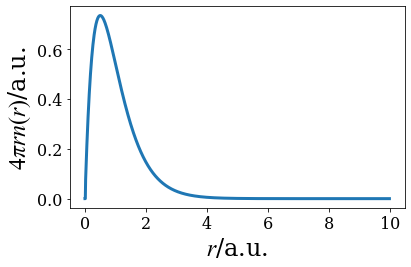

In [8]:
interval = h
x_forplot = np.arange(0.0,MaxI*interval,interval)
plt.plot(x_forplot,-ChDens[:MaxI],'-',lw=3)
#plt.axis([0,0.4,-0.0001,0.004])
#plt.axis([0,0.2,-0.008,0.0005])

#plt.axis([0,5,-0.0008,0.008])
#plt.title(r"Density of radial wave function ($4\pi r n(r)$)")
plt.xlabel(r"$r$/a.u.",fontsize=24)
plt.ylabel(r"$4\pi r n(r)$/a.u.",fontsize=24)
figname = 'density_H_atom.png'
plt.tight_layout()
plt.savefig(figname,dpi=300,format='png')
plt.show()

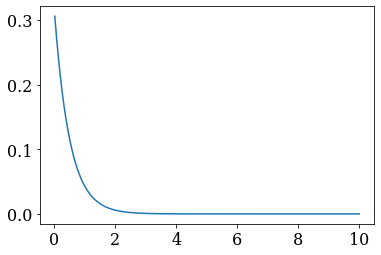

In [12]:
interval = h
x_forplot = np.arange(0.0,MaxI*interval,interval)
nx = np.zeros(len(x_forplot))
for i in range(1, MaxI):
    nx[i] = ChDens[i]/(x_forplot[i])
nx = -nx/(4.0*np.pi)
plt.plot(x_forplot[2:],nx[2:])
#plt.axis([0,2,-0.0001,0.0035])
plt.show()